In [81]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from matplotlib import pyplot as plt

In [ ]:
def compute_iou(truth, output_classes, num_classes: int):
    class_count = 0
    iou = 0.0
    for c in range(num_classes):
        # Create tensors with 1 for every pixel labelled with this class, and 0 otherwise. We then
        # add these tensors. The result has 2 for the intersection, and 1 or 2 for the union.

        truth_for_class = torch.where(truth == c, torch.ones_like(truth, dtype=torch.int),
                                      torch.zeros_like(truth, dtype=torch.int))

        output_for_class = torch.where(output_classes == c, torch.ones_like(output_classes, dtype=torch.int),
                                       torch.zeros_like(output_classes, dtype=torch.int))

        result = truth_for_class + output_for_class
        # View in 1D as bincount only supports 1D.
        # We expect values 0, 1, 2 for no object, one object and both objects respectively.
        counts = torch.bincount(result.view(-1), minlength=3)

        assert counts.size(0) == 3, 'Wrong number of bins: {}'.format(counts)

        intersection = counts[2].item()
        union = counts[1].item() + counts[2].item()
        
        print(f'class={c}, intersection={intersection}, union={union}')

        if union > 0:
            class_count += 1
            iou += intersection / union

    return iou / class_count

Ground truth:

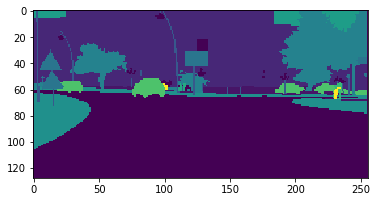

In [8]:
image = np.asarray(Image.open('../example-tiny-cityscapes/aachen/aachen_000000_000019_gtFine_labelIds.png'))
plt.imshow(np.where(image != 255, image, np.zeros_like(image)))

In [58]:
def rem255(a):
    return np.where(a != 255, a, np.zeros_like(a))

Ground truth downsampled to 16x32, the output size of the decoder:

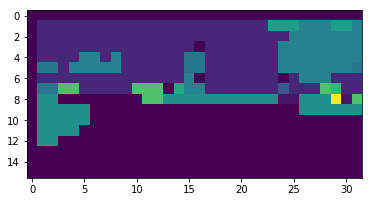

In [66]:
image_t = torch.tensor(image).unsqueeze(0).unsqueeze(0).float()
downsampled_t = F.interpolate(image_t, size=(16,32), mode='nearest')
downsampled = downsampled_t.numpy().squeeze()
downsampled.shape
plt.imshow(rem255(downsampled))

Upsample the image again, and compute the IOU

In [69]:
upsampled_t = F.interpolate(downsampled_t, size=(128,256), mode='nearest') #, align_corners=False
upsampled_t = upsampled_t.round()
upsampled = upsampled_t.numpy().squeeze()

array([  0.,   1.,   2.,   5.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,
        18., 255.], dtype=float32)

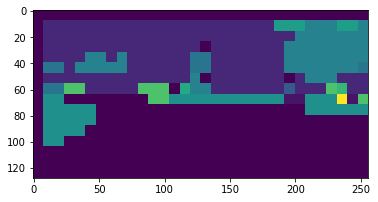

In [70]:
plt.imshow(np.where(upsampled != 255, upsampled, np.zeros_like(upsampled)))
np.unique(upsampled)

In [79]:
compute_iou(image_t, upsampled_t, 19)

0.3411806225105028

Directly optimise a 16x32 image so, when upscaled to 128x256, it matches the ground truth:

In [98]:
li = torch.rand(1, 20,16,32, requires_grad=True)
truth = torch.tensor(image).unsqueeze(0).long()

ce_loss = nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.Adam([li], lr=0.001)

losses = []
for i in range(10000):
    up = F.interpolate(li, size=(128,256), mode='bilinear')
    loss = ce_loss(up, truth)
    
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if i % 500 == 0:
        print(f'{i}: {loss}')
    
print('Done')

0: 3.0139176845550537
500: 1.7201625108718872
1000: 0.8143423199653625
1500: 0.39291131496429443
2000: 0.23552897572517395
2500: 0.17522184550762177
3000: 0.14818604290485382
3500: 0.13437117636203766
4000: 0.1266273558139801
4500: 0.12183939665555954
5000: 0.11862239986658096
5500: 0.11614368855953217
6000: 0.11396302282810211
6500: 0.11183629930019379
7000: 0.10988885909318924
7500: 0.10826878249645233
8000: 0.10689917206764221
8500: 0.10579486191272736
9000: 0.10487770289182663
9500: 0.10409264266490936
Done


In [103]:
output = F.interpolate(li.clone().detach(), size=(128,256), mode='bilinear').squeeze().numpy()

(20, 128, 256)


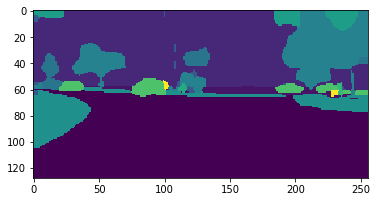

In [105]:
plt.imshow(rem255(output.argmax(0)))
plt.show()

In [128]:
compute_iou(truth, torch.tensor(output.argmax(0)), 20)

class=0, intersection=12823, union=14536
class=1, intersection=407, union=559
class=2, intersection=9243, union=10289
class=3, intersection=0, union=0
class=4, intersection=0, union=0
class=5, intersection=48, union=403
class=6, intersection=0, union=0
class=7, intersection=468, union=609
class=8, intersection=3259, union=3733
class=9, intersection=1945, union=2254
class=10, intersection=539, union=679
class=11, intersection=20, union=37
class=12, intersection=21, union=49
class=13, intersection=601, union=728
class=14, intersection=0, union=0
class=15, intersection=0, union=0
class=16, intersection=0, union=0
class=17, intersection=0, union=0
class=18, intersection=22, union=59
class=19, intersection=0, union=0


0.6744541768758298